In [1]:
import importlib as il

import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

from ipydex import Container
import symbtools as st
import pyblocksim as pbs
import boasim as bs

import original_curves as oc
from original_curves import apx

t, s = pbs.t, pbs.s
%matplotlib inline
%load_ext ipydex.displaytools

import time
print(time.ctime())

Thu Nov 21 15:19:54 2024


In [2]:
T = pbs.td.T
T_end = 12
# respect discrete time

tt = np.arange(0, int(T_end/T) + 1)*T

### Propofol as Bolus

Referring to slide 24 and following

Text(0, 0.5, 'relative sensitivity\n (relevant for BIS)')

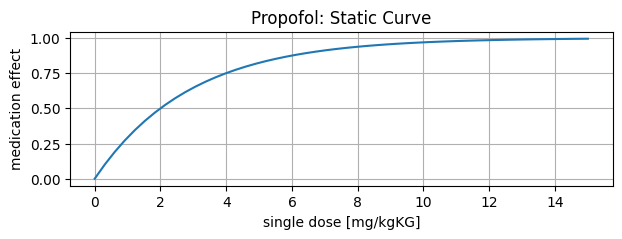

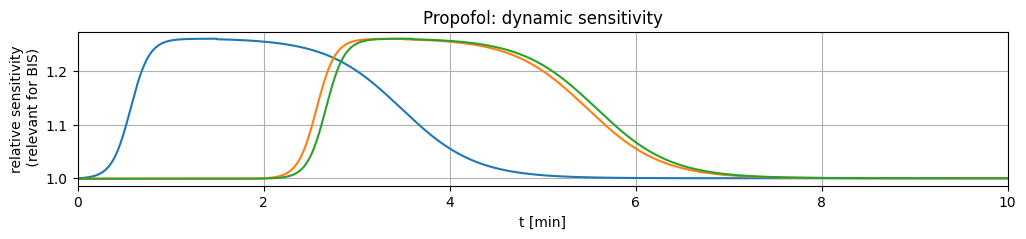

In [7]:
# preparation

il.reload(oc)
il.reload(pbs.td)


params = dict(reference_bp=100, reference_bis=1)
pfl = bs.dtPropofolBolus(input1=0, input2=0, params=params)

dd = np.linspace(0, 15)

plt.figure(figsize=(7, 2))
plt.grid()
plt.plot(dd, pfl.propofol_bolus_static_values_np(dd))
plt.title("Propofol: Static Curve")
plt.xlabel("single dose [mg/kgKG]")
plt.ylabel("medication effect")


tt = np.linspace(0, 20, 5000)

plt.figure(figsize=(12, 2))


plt.plot(tt, pfl.propofol_bolus_sensitivity_dynamics_np(tt))
plt.plot(tt, pfl.propofol_bolus_sensitivity_dynamics_np(tt-2))
plt.plot(tt, pfl.propofol_bolus_sensitivity_dynamics_np(tt-2.1))
plt.xticks(range(0, 20, 2))
plt.xlim(0, 10)
plt.grid()

plt.title("Propofol: dynamic sensitivity")
plt.xlabel("t [min]")
plt.ylabel("relative sensitivity\n (relevant for BIS)")
    
    

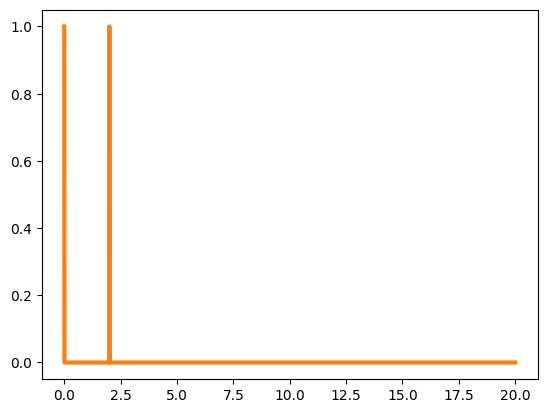

In [5]:
# table from slide 30
# input signal of boli
# original: u_expr_propofol_boli = sp.Piecewise((0.5, apx(t, 0)), (1.5, apx(t, 2)), (0, True))
u_expr_propofol_boli = sp.Piecewise((1, apx(t, 0)), (1, apx(t, 2)), (0, True))
u_func = st.expr_to_func(t, u_expr_propofol_boli)

plt.plot(tt, u_func(tt), "-", color="tab:orange", lw=3)


In [6]:
def plot_results():
    """
    Plot function to visualize internals of Propofol-Block
    """
    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, 1, figsize=(15, 12));

    ax1.plot(kk*T, xx[:, counter_idcs], label="counters")
    ax1.legend()
    ax2.plot(kk*T, pfl.propofol_bolus_sensitivity_dynamics_np(6-xx[:, counter_idcs].T*T), label="isolated sensitivity")
    ax2.legend()
    ax3.plot(kk*T, xx[:, get_idcs(pfl.x2)], label="combined sensitivity for bis")
    ax3.legend()
    ax3.set_ylim(.98, 1.31)

    # amplitude debugging
    ax4.plot(kk, xx[:, bp_amplitude_idcs], ".-", ms=1, label="bp effect amplitude")
    #ax4.plot(kk, xx[:, 3], "-k")
    #ax4.plot(kk, u_func(kk*T), "-", color="magenta", lw=0.5)
    ax4.legend()
    ax4.grid()
    
    # plot bp effects of single dose
    ax = ax5
    single_dose_effect_dynamics_func = st.expr_to_func(pbs.td.t, pfl.bp_effect_dynamics_expr)
    for idx_c, idx_bpa in zip(counter_idcs, bp_amplitude_idcs):
        counter_time = xx[:, idx_c]*T
        ee = single_dose_effect_dynamics_func(counter_time)*xx[:, idx_bpa]
        ax.hlines([-8, -18.6], 0, 120, color="0.5", alpha=0.3)
        ax.plot(kk, ee, ".-", ms=1, label="bp effects single dose")
        ax.legend()

    ax6.plot(kk*T, bo[bp_delay_block], label="bp effect")
    ax6.legend()
    ax6.grid()

    ax7.set_title("debug")
    x3_index = get_idcs(pfl.x3)
    ax7.plot(kk, xx[:, x3_index], "-", label="x3_c_ppf_ib_bp")
    ax7.legend()
    ax7.grid()


# will be used below
def get_idcs(symbs):
    if isinstance(symbs, sp.Symbol):
        symbs = (symbs,)
    assert isinstance(symbs, (list, tuple))
    
    idcs = np.array([i for (i, s) in enumerate(pbs.td.ds.all_state_vars) if sp.sympify(s) in symbs])
    return idcs


counter_idcs := array([ 8, 11, 14])

---

bp_amplitude_idcs := array([10, 13, 16])

---

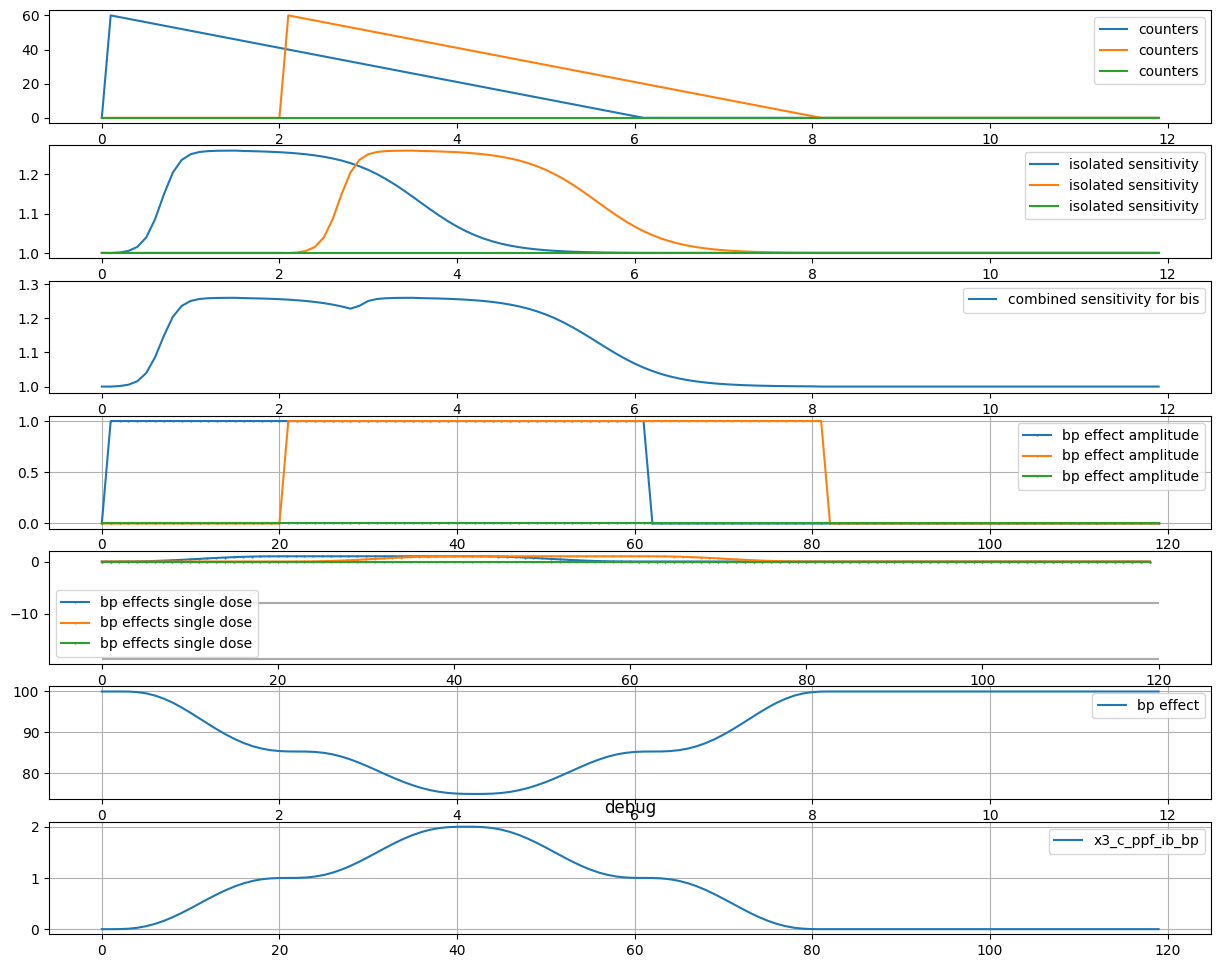

In [9]:

il.reload(oc); il.reload(pbs.td); il.reload(bs);

dt = 1

bp_normal = 100
u_func = st.expr_to_func(t, u_expr_propofol_boli)

l1 = pbs.td.get_loop_symbol()
bp_sum  = pbs.td.StaticBlock(output_expr=100 + l1)
bp_delay_block = pbs.td.dtDelay1(input1=bp_sum.Y)


# dtPropofolBolus - output: Propfol-related BP difference
params = dict(reference_bp=bp_normal, reference_bis=1)
pfl = bs.dtPropofolBolus(input1=u_expr_propofol_boli, input2=bp_delay_block.Y, params=params)
pbs.td.set_loop_symbol(l1, pfl.Y)

T_end = 12
N_steps = int(T_end/T)

bp_start = bp_normal
iv = {bp_delay_block.x1:bp_start, pfl.x1: 0, pfl.x2: 1}

kk, xx, bo = pbs.td.blocksimulation(N_steps, iv=iv, rhs_options={"use_sp2c": False})

counter_symbols = pfl.counter_states[::3]

all_idcs = np.arange(len(pbs.td.ds.all_state_vars))
counter_idcs = get_idcs(counter_symbols) ##:
bp_amplitude_idcs = counter_idcs + 2 ##:

plot_results()

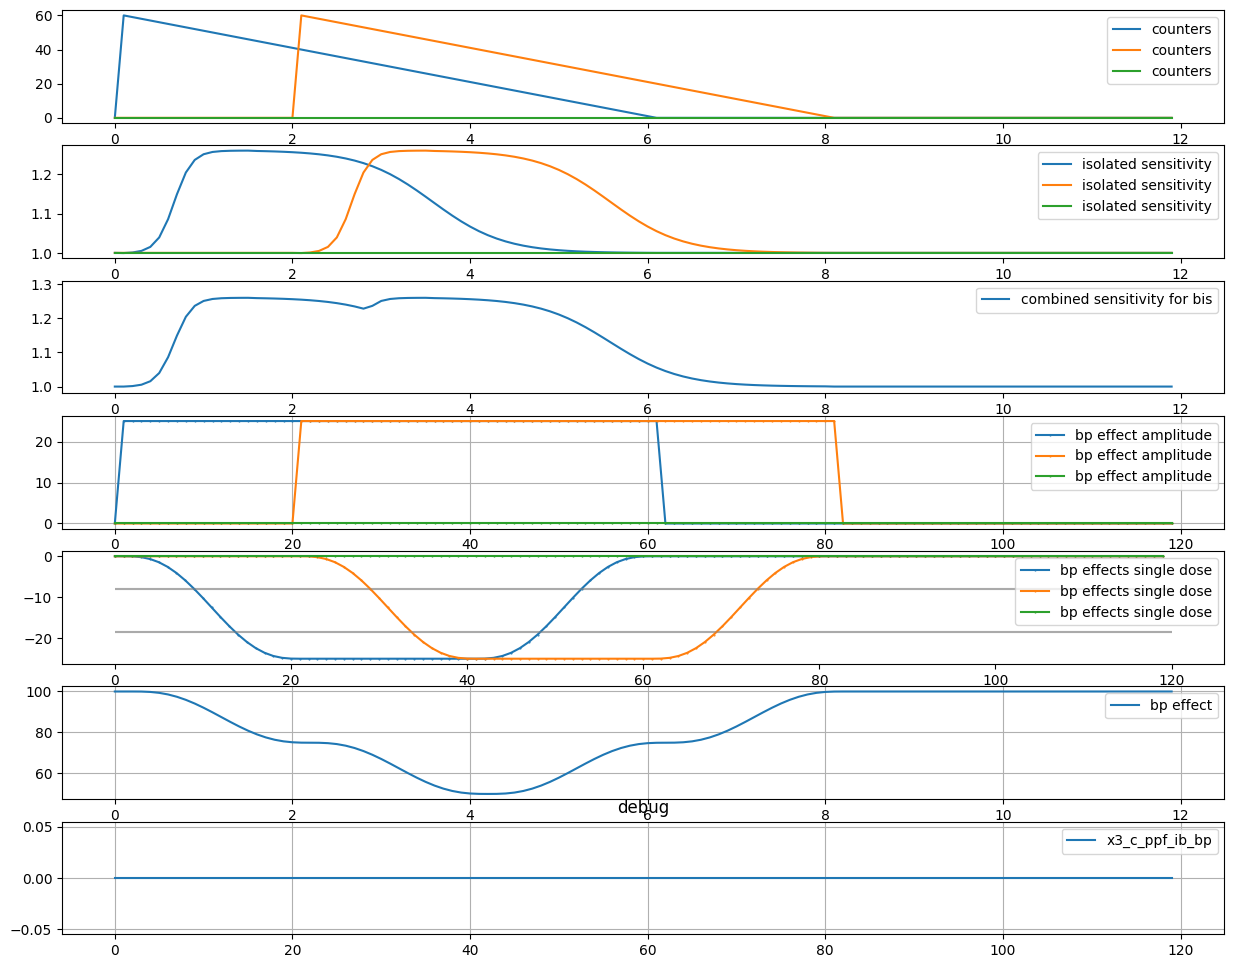

In [48]:
plot_results()

array([3])

In [24]:
bs.dtPropofolBolus?

displaytools detected a SyntaxError in the original cell



Init signature: bs.dtPropofolBolus(*args, **kwargs)
Docstring:     
This block models blood pressure increase due to Propofol bolus doses.
It uses 1state counters. Each counter, is followed by associated auxiliary values:
i + 0: counter
i + 1: effect amplitude considering sensitivity (used for BIS)
i + 2: effect amplitude without considering sensitivity (used for HR/BP)
(also considered part of the counter state components ("counter states"))
File:           /media/hdd-a2/space/Nextcloud/tmp2023/anesthesia-model/boasim_repo/src/boasim/blocks.py
Type:           type
Subclasses:     

In [20]:
bs?

    


displaytools detected a SyntaxError in the original cell



Type:        module
String form: <module 'boasim' from '/media/hdd-a2/space/Nextcloud/tmp2023/anesthesia-model/boasim_repo/src/boasim/__init__.py'>
File:        /media/hdd-a2/space/Nextcloud/tmp2023/anesthesia-model/boasim_repo/src/boasim/__init__.py
Docstring:   <no docstring>

In [10]:
dt = 3
T_end = 40

u_expr_propofol_boli = sp.Piecewise((0.5, apx(t, 0)), (1.5, apx(t, 2)), (1.5, apx(t, 12)), (1.5, apx(t, 18)), (1.5, apx(t, 25)), (0, True))
u_func = st.expr_to_func(t, u_expr_propofol_boli)

pfl.set_inputs(input1=u_expr_propofol_boli, input2=bp_delay_block.Y)
pbs.td.generate_input_func()

N_steps = int(T_end/T)

bp_start = bp_normal
iv = {bp_delay_block.x1:bp_start, pfl.x1: 0, pfl.x2: 1}

kk, xx, bo = pbs.td.blocksimulation(N_steps, iv=iv)

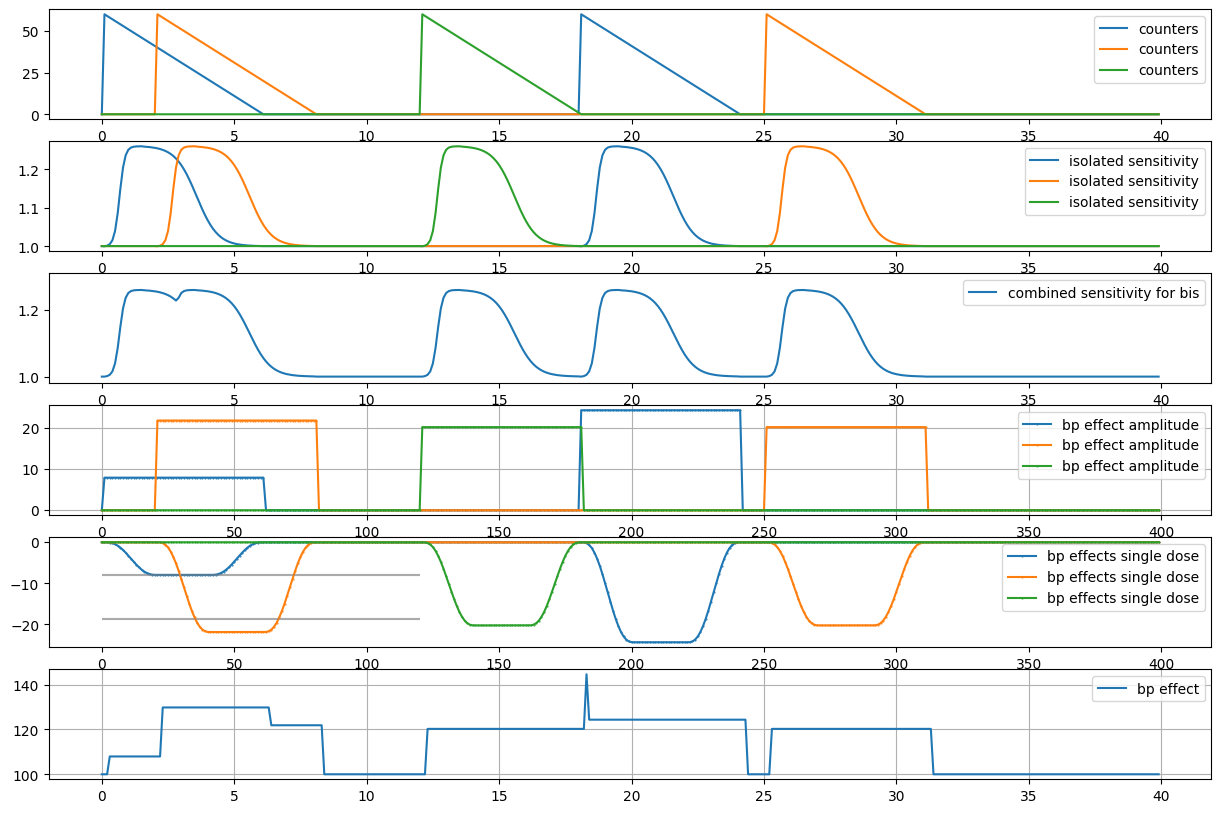

In [11]:
plot_results()